In [13]:
import pickle

from collections import Counter

import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm, tqdm_notebook

import numpy as np

from sklearn.metrics.pairwise import cosine_distances
from sklearn.neighbors        import NearestNeighbors

import torch
import torch.nn            as nn
import torch.nn.functional as F
import torch.optim         as optim
from torch.utils.data.dataset import random_split
from torchvision              import datasets 
from torchvision              import transforms

# General settings and normalization tools

In [14]:
do_train          = True
do_eval           = True
calib_prop        = 0.1
model_path        = '../models/CIFAR_CNN.pt'
deep_knn_path     = '../models/deep_knn.pkl'
batch_size        = 128
device            = torch.device('cuda')
means             = torch.tensor((0.4914, 0.4822, 0.4465)).to(device)
stds              = torch.tensor((0.2023, 0.1994, 0.2010)).to(device)
normalize         = lambda x: (x - means) / stds
normalize_red     = lambda x: (x - means[0]) / stds[0]
normalize_green   = lambda x: (x - means[1]) / stds[1]
normalize_blue    = lambda x: (x - means[2]) / stds[2]
reverse_normalize = lambda x: (x * stds) + means

In [15]:
def display_img(img):
    img_data = lambda img: reverse_normalize(img.squeeze().permute(1,2,0)).data.cpu().numpy().clip(0, 1)
    plt.imshow(img_data(img))    

# Data loading

In [16]:
cifar_cats = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
]

In [17]:
training_dataset = datasets.CIFAR10(
    '../data',
    train = True,
    download = True,
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(means, stds)
        ]
    )
)

train_set_size               = len(training_dataset)
calib_size                   = round(calib_prop * train_set_size)
train_dataset, calib_dataset = random_split(
    dataset = training_dataset, 
    lengths = [train_set_size - calib_size, calib_size]
)
print(f'Train dataset size: {len(train_dataset)}')
print(f'Calibration dataset size: {len(calib_dataset)}')

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    shuffle = True,
    batch_size = batch_size
)

Files already downloaded and verified
Train dataset size: 45000
Calibration dataset size: 5000


In [18]:
test_dataset = datasets.CIFAR10(
    '../data',
    train = False,
    download = True,
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(means, stds)
        ]
    )
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    shuffle = False,
    batch_size = 2 * batch_size
)

Files already downloaded and verified


deer


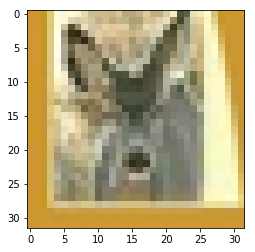

In [19]:
img, y = train_dataset[510]
display_img(img.to(device))
print(cifar_cats[y])

dog


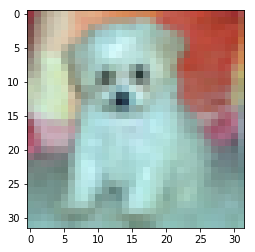

In [20]:
img, y = test_dataset[510]
display_img(img.to(device))
print(cifar_cats[y])

# Training and evaluation tools

In [21]:
def train(model, device, train_loader, optimizer, criterion, n_epochs, log_interval):
    model.train()
    for epoch in tqdm_notebook(range(n_epochs), desc = 'Epochs'):
        for batch_idx, (X, y) in tqdm_notebook(enumerate(train_loader), total = len(train_loader), desc = 'Batches', leave = False):
            X, y       = X.to(device), y.to(device)
            optimizer.zero_grad()
            *_, y_pred = model(X)
            loss       = criterion(y_pred, y)
            loss.backward()
            optimizer.step()
            if batch_idx % log_interval == 0:
                print(f'Train epoch {epoch}: [{batch_idx * len(X):5d}/{len(train_loader.dataset):5d}] Loss: {loss.item():7.4f}')

In [22]:
def evaluate(model, device, test_loader, criterion):
    model.eval()
    test_set_size = len(test_loader.dataset)
    correct_answers = 0
    sum_loss = 0
    with torch.no_grad():
        for X, y in tqdm_notebook(test_loader):
            X, y             = X.to(device), y.to(device)
            *_, y_pred       = model(X)
            class_pred       = y_pred.argmax(dim = 1)
            correct_answers += (y == class_pred).sum().item()
            sum_loss        += criterion(y_pred, y).item()
    accuracy = correct_answers / test_set_size
    average_loss = sum_loss / len(test_loader)
    
    return accuracy, average_loss

# Model

In [23]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3 , 16 , 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 16 , 3, padding = 1)
        self.conv3 = nn.Conv2d(16, 32,  3, padding = 1)
        self.conv4 = nn.Conv2d(32, 32,  3, padding = 1)
        self.fc1   = nn.Linear(32 * 8 * 8, 128)
        self.fc2   = nn.Linear(128       , 10)
        
    def forward(self, x):
        out_conv1 = F.dropout(F.relu(self.conv1(x)), 0.2, training = self.training)
        out_conv2 = F.dropout(F.relu(self.conv2(out_conv1)), 0.2, training = self.training)
        out_pool1 = F.max_pool2d(out_conv2, kernel_size = (2, 2))
        out_conv3 = F.dropout(F.relu(self.conv3(out_pool1)), 0.2, training = self.training)
        out_conv4 = F.dropout(F.relu(self.conv4(out_conv3)), 0.2, training = self.training)
        out_pool2 = F.max_pool2d(out_conv4, kernel_size = (2, 2))
        out_view  = out_pool2.view(-1, 32 * 8 * 8)
        out_fc    = F.dropout(F.relu(self.fc1(out_view)), 0.2, training = self.training)
        out       = self.fc2(out_fc)
        
        return out_conv1, out_conv2, out_conv3, out_conv4, out

# Training

In [24]:
criterion = nn.CrossEntropyLoss()

In [25]:
if do_train:
    cnn       = CNN().to(device)
    optimizer = optim.Adam(cnn.parameters())
    train(cnn, device, train_loader, optimizer, criterion, 15, len(train_loader) // 5)
    torch.save(cnn.state_dict(), model_path)

Train epoch 0: [    0/45000] Loss:  2.3086
Train epoch 0: [ 8960/45000] Loss:  1.8778
Train epoch 0: [17920/45000] Loss:  1.6513
Train epoch 0: [26880/45000] Loss:  1.5116
Train epoch 0: [35840/45000] Loss:  1.5295
Train epoch 0: [44800/45000] Loss:  1.4814


Train epoch 1: [    0/45000] Loss:  1.3638
Train epoch 1: [ 8960/45000] Loss:  1.4038
Train epoch 1: [17920/45000] Loss:  1.3459
Train epoch 1: [26880/45000] Loss:  1.3118
Train epoch 1: [35840/45000] Loss:  1.2170
Train epoch 1: [44800/45000] Loss:  1.3680


Train epoch 2: [    0/45000] Loss:  1.3633
Train epoch 2: [ 8960/45000] Loss:  1.3157
Train epoch 2: [17920/45000] Loss:  1.1572
Train epoch 2: [26880/45000] Loss:  0.9770
Train epoch 2: [35840/45000] Loss:  1.1619
Train epoch 2: [44800/45000] Loss:  1.1307


Train epoch 3: [    0/45000] Loss:  0.9474
Train epoch 3: [ 8960/45000] Loss:  1.1755
Train epoch 3: [17920/45000] Loss:  1.1362
Train epoch 3: [26880/45000] Loss:  1.1991
Train epoch 3: [35840/45000] Loss:  1.1207
Train epoch 3: [44800/45000] Loss:  0.9787


Train epoch 4: [    0/45000] Loss:  1.1603
Train epoch 4: [ 8960/45000] Loss:  0.9280
Train epoch 4: [17920/45000] Loss:  0.9484
Train epoch 4: [26880/45000] Loss:  0.9293
Train epoch 4: [35840/45000] Loss:  0.9054
Train epoch 4: [44800/45000] Loss:  0.9589


Train epoch 5: [    0/45000] Loss:  0.9165
Train epoch 5: [ 8960/45000] Loss:  0.8202
Train epoch 5: [17920/45000] Loss:  0.8560
Train epoch 5: [26880/45000] Loss:  1.0790
Train epoch 5: [35840/45000] Loss:  0.9144
Train epoch 5: [44800/45000] Loss:  0.8314


Train epoch 6: [    0/45000] Loss:  0.8161
Train epoch 6: [ 8960/45000] Loss:  0.8689
Train epoch 6: [17920/45000] Loss:  0.9026
Train epoch 6: [26880/45000] Loss:  0.8845
Train epoch 6: [35840/45000] Loss:  1.0420
Train epoch 6: [44800/45000] Loss:  0.9211


Train epoch 7: [    0/45000] Loss:  0.7835
Train epoch 7: [ 8960/45000] Loss:  0.8380
Train epoch 7: [17920/45000] Loss:  0.8869
Train epoch 7: [26880/45000] Loss:  0.7868
Train epoch 7: [35840/45000] Loss:  0.8379
Train epoch 7: [44800/45000] Loss:  0.6780


Train epoch 8: [    0/45000] Loss:  0.7818
Train epoch 8: [ 8960/45000] Loss:  0.7702
Train epoch 8: [17920/45000] Loss:  0.6867
Train epoch 8: [26880/45000] Loss:  0.7907
Train epoch 8: [35840/45000] Loss:  0.8146
Train epoch 8: [44800/45000] Loss:  0.9369


Train epoch 9: [    0/45000] Loss:  0.6753
Train epoch 9: [ 8960/45000] Loss:  0.7047
Train epoch 9: [17920/45000] Loss:  0.7197
Train epoch 9: [26880/45000] Loss:  0.8518
Train epoch 9: [35840/45000] Loss:  0.9079
Train epoch 9: [44800/45000] Loss:  0.8323


Train epoch 10: [    0/45000] Loss:  0.7070
Train epoch 10: [ 8960/45000] Loss:  0.7296
Train epoch 10: [17920/45000] Loss:  0.5823
Train epoch 10: [26880/45000] Loss:  0.7103
Train epoch 10: [35840/45000] Loss:  0.8875
Train epoch 10: [44800/45000] Loss:  0.8108


Train epoch 11: [    0/45000] Loss:  0.7491
Train epoch 11: [ 8960/45000] Loss:  0.5201
Train epoch 11: [17920/45000] Loss:  0.5633
Train epoch 11: [26880/45000] Loss:  0.6967
Train epoch 11: [35840/45000] Loss:  0.6628
Train epoch 11: [44800/45000] Loss:  0.7378


Train epoch 12: [    0/45000] Loss:  0.7322
Train epoch 12: [ 8960/45000] Loss:  0.6255
Train epoch 12: [17920/45000] Loss:  0.7149
Train epoch 12: [26880/45000] Loss:  0.7316
Train epoch 12: [35840/45000] Loss:  0.7389
Train epoch 12: [44800/45000] Loss:  0.6942


Train epoch 13: [    0/45000] Loss:  0.8005
Train epoch 13: [ 8960/45000] Loss:  0.6320
Train epoch 13: [17920/45000] Loss:  0.7905
Train epoch 13: [26880/45000] Loss:  0.6040
Train epoch 13: [35840/45000] Loss:  0.7756
Train epoch 13: [44800/45000] Loss:  0.6250


Train epoch 14: [    0/45000] Loss:  0.7098
Train epoch 14: [ 8960/45000] Loss:  0.6293
Train epoch 14: [17920/45000] Loss:  0.6144
Train epoch 14: [26880/45000] Loss:  0.6685
Train epoch 14: [35840/45000] Loss:  0.8373
Train epoch 14: [44800/45000] Loss:  0.7474



In [14]:
cnn = CNN().to(device)
cnn.load_state_dict(torch.load(model_path))
cnn.eval()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [15]:
if do_eval:
    accuracy, avg_loss = evaluate(cnn, device, train_loader, criterion)
    print(f'[Train] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')
    accuracy, avg_loss = evaluate(cnn, device, test_loader, criterion)
    print(f'[Test] Accuracy: {100 * accuracy:5.2f}%, loss: {avg_loss:7.4f}')


[Train] Accuracy: 85.01%, loss:  0.4832



[Test] Accuracy: 73.07%, loss:  0.7791


Real label: 1
Predicted label: 1


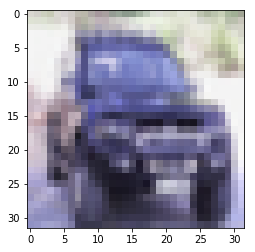

In [16]:
ex_id = 9
X, y  = test_dataset[ex_id]
X     = X.to(device)
img   = X.permute(1, 2, 0)
img   = reverse_normalize(img)
plt.imshow(img.cpu())
print(f'Real label: {y}')
print(f'Predicted label: {cnn(X.unsqueeze(0))[-1].argmax().item()}')

# Deep KNN

In [28]:
class DeepKNN():
    def __init__(self, model, device, train_dataset, calib_dataset, 
                 batch_size, n_neighbors, n_embs):
        self.model         = model
        self.device        = device
        self.train_dataset = train_dataset
        self.calib_dataset = calib_dataset
        self.batch_size    = batch_size
        self.n_neighbors   = n_neighbors
        self.n_embs        = n_embs
        (
            self.conv_features, 
            self.train_targets, 
            self.train_predictions
        )                    = self._build_emb_spaces()
        self.neighs          = self._build_neighs()
        self.alpha_calib_sum = self._build_calibration()
        
    def _build_emb_spaces(self):
        print('Building the embedding spaces from the training set.')
        sequential_train_loader = torch.utils.data.DataLoader(
            self.train_dataset,
            shuffle    = False,
            batch_size = self.batch_size
        )
        
        conv_features = [[] for _ in range(self.n_embs)]
        targets       = []
        predictions   = []
        print('\tRunning predictions')
        self.model.eval()
        for X, y in sequential_train_loader:
            X                  = X.to(self.device)
            *out_convs, y_pred = self.model(X)
            for i, out_conv in enumerate(out_convs):
                conv_feat = out_conv.view(out_conv.size(0), -1).cpu().detach().numpy()
                conv_features[i].append(conv_feat)
            targets.append(y.numpy())
            predictions.append(y_pred.cpu().detach().numpy())
        print('\tConcatenating results')
        conv_features = [np.concatenate(out_convs) for out_convs in conv_features]
        targets       = np.concatenate(targets)
        predictions   = np.concatenate(predictions, axis = 0)
        
        return conv_features, targets, predictions

    def _build_calibration(self):
        print('Building calibration set.')
        sequential_calib_loader = torch.utils.data.DataLoader(
            self.calib_dataset,
            shuffle    = False,
            batch_size = self.batch_size
        )
        alpha_by_batch = [self._alpha(X, y.numpy()) for X, y in sequential_calib_loader]
        alpha_values   =  np.concatenate(alpha_by_batch)
        c              = Counter(alpha_values)
        alpha_sum_cum  = []

        for alpha_value in range(self.n_embs * self.n_neighbors, -1, -1):
            alpha_sum_cum.append(c[alpha_value] + (alpha_sum_cum[-1] if len(alpha_sum_cum) > 0 else 0))
            
        return np.array(alpha_sum_cum[::-1])
    
    def _build_neighs(self):
        print('Building Nearest Neighbor finders.')
        return [
            NearestNeighbors(
                n_neighbors = self.n_neighbors, 
                metric      = 'cosine'
            ).fit(feats) 
            for feats in self.conv_features
        ]
        
    def _alpha(self, X, y):
        neighbors_by_layer, _  = self._get_closest_points(X)
        closest_points_classes = self.train_targets[neighbors_by_layer]
        same_class_neighbors   = closest_points_classes != y.reshape(y.shape[0], 1, 1)
        same_class_neighbors   = same_class_neighbors.reshape(-1, self.n_neighbors * self.n_embs)
        alpha                  = same_class_neighbors.sum(axis = 1)
        
        return alpha

    def _compute_nonconformity(self, X):
        neighbors_by_layer, _  = self._get_closest_points(X)
        closest_points_label   = self.train_targets[neighbors_by_layer]
        closest_points_label   = closest_points_label.reshape(-1, 24)
        nonconformity          = [(closest_points_label != label).sum(axis = 1) for label in range(10)]
        nonconformity          = np.stack(nonconformity, axis = 1)
        
        return nonconformity
    
    def _compute_p_value(self, X):
        nonconformity = self._compute_nonconformity(X)
        empirical_p_value      = self.alpha_calib_sum[nonconformity] / len(self.calib_dataset)
        
        return empirical_p_value
    
    def _get_closest_points(self, X):
        *out_convs, y_pred = self.model(X.to(device))
        neighbors_by_layer = []
        for i, (neigh, layer_emb) in enumerate(zip(self.neighs, out_convs)):
            emb       = layer_emb.detach().cpu().view(X.size(0), -1).numpy()
            neighbors = neigh.kneighbors(emb, return_distance = False) 
            neighbors_by_layer.append(neighbors)
        return np.stack(neighbors_by_layer, axis = 1), y_pred

    def predict(self, X):
        p_value     = self._compute_p_value(X)
        y_pred      = p_value.argmax(axis = 1)
        # Partitioning according to the second to last value in order to compute
        # credibility and confidence
        partition   = np.partition(p_value, -2)
        credibility = partition[:, -1]
        confidence  = 1 - partition[:, -2]
        
        return y_pred, confidence, credibility
    
    def predict_interpretation(self, X, y = None):
        img_data = lambda img: reverse_normalize(img.to(device).squeeze().permute(1,2,0)).data.cpu().numpy().clip(0, 1)
        plt.figure(figsize = (12, 6))
        gs       = gridspec.GridSpec(4, 4 + self.n_neighbors)
        ax_big   = plt.subplot(gs[:, :4])
        ax_grid  = [[plt.subplot(gs[i, j]) for j in range(4, 4 + self.n_neighbors)] for i in range(4)]
        ax_big.imshow(img_data(X))
        ax_big.axis('off')
        neighbors_by_layer, y_pred = self._get_closest_points(X.unsqueeze(0))
        print(neighbors_by_layer)
        print(y_pred)
        for ax_line, closest_layer in zip(ax_grid, neighbors_by_layer[0]):
            for ax_cell, train_ex_id in zip(ax_line, closest_layer):
                img = self.train_dataset[train_ex_id][0]
                ax_cell.imshow(img_data(img))
                ax_cell.axis('off')

        if y is not None:
            print(f'Real class: {cifar_cats[y]}')
        print(f'Predicted class: {cifar_cats[y_pred.argmax(dim = 1).cpu().item()]}')
        
        return y_pred

In [29]:
# dataset shrinking for laptop prototyping, to comment / remove while on desktop
n                = 5000
train_dataset, _ = random_split(train_dataset, [n, len(train_dataset) - n])
calib_dataset, _ = random_split(calib_dataset, [n, len(calib_dataset) - n])
print(len(train_dataset), len(calib_dataset))

5000 5000


In [30]:
deep_knn = DeepKNN(
    model         = cnn, 
    device        = device, 
    train_dataset = train_dataset,
    calib_dataset = calib_dataset,
    batch_size    = batch_size,
    n_neighbors   = 6,
    n_embs        = 4 
)

Building the embedding spaces from the training set.
	Running predictions
	Concatenating results
Building Nearest Neighbor finders.
Building calibration set.


In [ ]:
# with open(deep_knn_path, mode = 'wb') as deep_knn_file:    
#     pickle.dump(deep_knn, deep_knn_file)

In [31]:
batch, y = next(iter(train_loader))
y        = y.numpy()

In [32]:
y_pred, confidence, credibility = deep_knn.predict(batch)

In [33]:
print('Accuracy:                                  \t', (y == y_pred).mean())
print('average confidence for correct predictions:\t', confidence[y == y_pred].mean())
print('average confidence for incorrect predictions:\t', confidence[y != y_pred].mean())
print('average credibility for correct predictions:\t', credibility[y == y_pred].mean())
print('average credibility for incorrect predictions:\t', credibility[y != y_pred].mean())

Accuracy:                                  	 0.640625
average confidence for correct predictions:	 0.6552097560975612
average confidence for incorrect predictions:	 0.6021086956521738
average credibility for correct predictions:	 0.7317731707317073
average credibility for incorrect predictions:	 0.623804347826087


[[[1645 1505 2712  927 2393 4229]
  [1645 2393 1505 4229 2712 2242]
  [1645 3341 1416 2283 1833 2469]
  [3389 3341 1645 1416 4290  670]]]
tensor([[  2.4974,   7.0151,  -5.4357,  -8.8826, -11.2383, -12.7119,  -7.5406,
         -11.3617,   8.6860,  -0.2574]], device='cuda:0',
       grad_fn=<AddmmBackward>)
Real class: ship
Predicted class: ship


tensor([[  2.4974,   7.0151,  -5.4357,  -8.8826, -11.2383, -12.7119,  -7.5406,
         -11.3617,   8.6860,  -0.2574]], device='cuda:0',
       grad_fn=<AddmmBackward>)

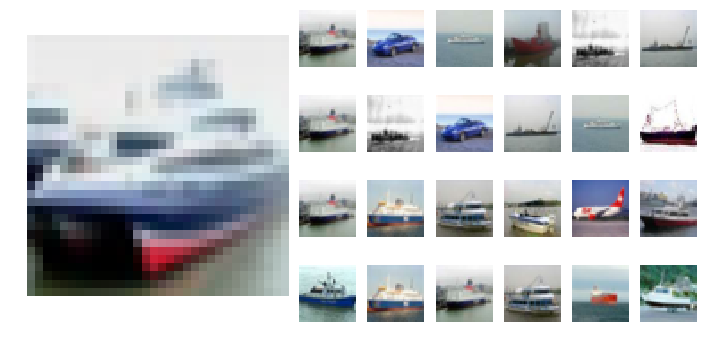

In [34]:
deep_knn.predict_interpretation(*test_dataset[1])

# Adversarial examples

In [35]:
def generate_adv_example(model, epsilon, criterion, X):
    X.requires_grad = True
    *_, y_pred      = model(X)
    loss            = criterion(y_pred, y_pred.argmax(dim = 1))
    loss.backward()
    adv_example     = X + epsilon * X.grad.sign()
    
    # Clamping the result to [0, 1] in each channel.
    # I don't think that there exist a multidimensional clamp function.
    for channel, norm_func in enumerate([normalize_red, normalize_green, normalize_blue]):
        adv_example[:, channel, ...].clamp_(norm_func(0), norm_func(1))
    
    return adv_example

In [36]:
def adv_sample_process(model, epsilon, X, y):
    source       = X.unsqueeze(0).to(device)
    *_, y_pred   = model(source)
    adv_example  = generate_adv_example(model, epsilon, criterion, source)
    *_, adv_pred = cnn(adv_example)
    for i in range(10):
        print(f'Class {i}: {y_pred[0, i]:6.4f} \t->\t {adv_pred[0, i]:^6.4f}')
    plt.figure(figsize = (15, 10))
    plt.subplot(1, 2, 1)
    display_img(source)
    plt.subplot(1, 2, 2)
    display_img(adv_example)
    print(f'Real label: {cifar_cats[y]}')
    print(f'Predicted label: {cifar_cats[adv_pred[0].argmax().item()]}')

In [43]:
ex_id = 5
X, y = test_dataset[ex_id]
# adv_sample_process(cnn, 0.15, X, y)

In [44]:
deep_knn.predict(X.unsqueeze(0))

(array([6]), array([0.7248]), array([0.7158]))

[[[ 938  659 1209 1329 4997 4355]
  [1418 4355 4195 1413 4591 1179]
  [4195  970 1389  311 1065 1268]
  [1065  970  311 1389 3841  160]]]
tensor([[-5.7415, -7.2635,  0.2687,  2.4683, -0.2281,  2.5631,  5.2279, -3.2148,
         -5.3381, -3.3980]], device='cuda:0', grad_fn=<AddmmBackward>)
Predicted class: frog


tensor([[-5.7415, -7.2635,  0.2687,  2.4683, -0.2281,  2.5631,  5.2279, -3.2148,
         -5.3381, -3.3980]], device='cuda:0', grad_fn=<AddmmBackward>)

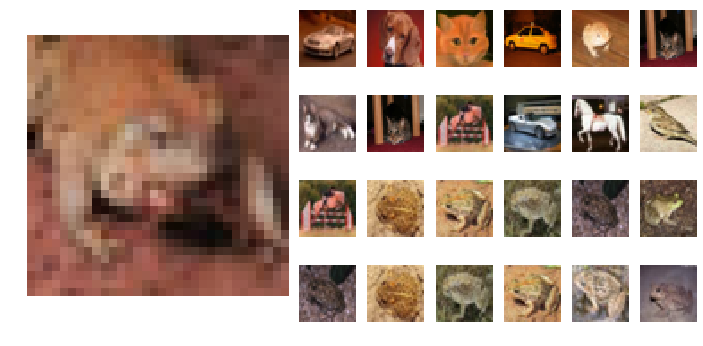

In [45]:
deep_knn.predict_interpretation(X)

[[[ 938  659 1209 1329 4997 1501]
  [4355 4195 1418 1413 4591 3170]
  [4195  970 1389 3372 4355 2783]
  [1065  970  788 1389 4195 2822]]]
tensor([[-5.9106, -6.7702, -0.6150,  4.2965, -2.5258,  4.8300,  1.4547,  0.5360,
         -5.2342, -2.2663]], device='cuda:0', grad_fn=<AddmmBackward>)
Real class: frog
Predicted class: dog


tensor([[-5.9106, -6.7702, -0.6150,  4.2965, -2.5258,  4.8300,  1.4547,  0.5360,
         -5.2342, -2.2663]], device='cuda:0', grad_fn=<AddmmBackward>)

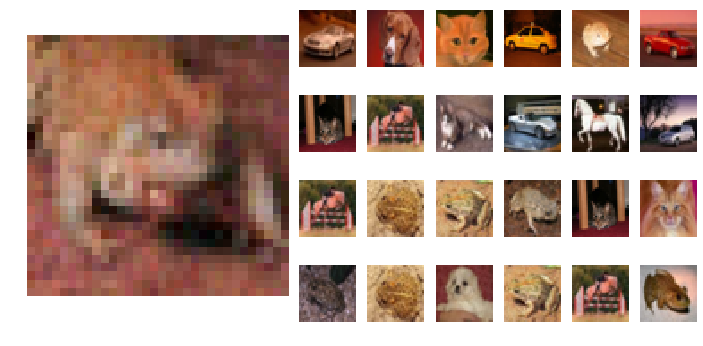

In [53]:
X_adv = generate_adv_example(cnn, 0.15, criterion, X.unsqueeze(0).to(device))
deep_knn.predict_interpretation(X_adv.squeeze(), y)